<img src="https://devra.ai/analyst/notebook/3945/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">
  <div style="font-size:150%; color:#FEE100"><b>Student Mental Health and Academic Pressure Analysis</b></div>
  <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div>
</div>

A curious exploration into how academic pressure relates to other factors in student mental health. If you find this analysis useful, please upvote it.

## Table of Contents

- [Imports and Setup](#Imports-and-Setup)
- [Data Loading and Exploration](#Data-Loading-and-Exploration)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Visualizations](#Visualizations)
- [Predictive Modeling](#Predictive-Modeling)
- [Discussion and Future Work](#Discussion-and-Future-Work)

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib backend and enable inline plotting
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
plt.switch_backend('Agg')

%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

sns.set(style='whitegrid')

# Define the path to the CSV file
file_path = '/kaggle/input/student-mental-health-and-academic-pressure/Student_Mental_Health_Academic_Pressure_2025.csv - Form Responses 1.csv'


In [2]:
# Data Loading and Exploration

# Load the dataset
df = pd.read_csv(file_path, encoding='utf-8', delimiter=',')

# Display the first few rows of the dataset to get a grip on its content
df.head()

# Convert the 'Timestamp' column to datetime if it exists
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Quick overview of the data
df.info()

# Summary statistics for numeric columns
df.describe(include=[np.number])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Timestamp                                              33 non-null     datetime64[ns]
 1   Age Group                                              33 non-null     object        
 2     Gender
                                              33 non-null     object        
 3     Current Education Level                              33 non-null     object        
 4     How much academic pressure do you feel?              33 non-null     int64         
 5    How often do you feel stressed due to studies?        33 non-null     object        
 6     How many hours do you sleep on average per night?    33 non-null     object        
 7     What is the main cause of your academic stress?      33 non-null     obj

,How much academic pressure do you feel?
count,33.000000
mean,3.878788
std,0.992395
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [3]:
# Data Cleaning and Preprocessing

# Trim whitespace from column names for consistency and easier access
df.columns = [col.strip() for col in df.columns]

# Rename columns for clarity (if necessary).
# For example, we define the academic pressure column name.
pressure_col = 'How much academic pressure do you feel?'  

# Since the original column might have extra spaces, we try to remove them
df.rename(columns=lambda x: x.strip(), inplace=True)

# Display the new column names
print('Columns in the dataset:', df.columns.tolist())

# Handle missing values
# Here, we drop rows that are missing the target variable.
df = df.dropna(subset=[pressure_col])

# For the remaining missing values in predictor variables, we can either drop them or impute.
# As an example, we will impute numeric columns with the median and categorical columns with the mode.

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print('Numeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)

from sklearn.impute import SimpleImputer

# Impute missing values in numeric columns
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Impute missing values in categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Verify that there are no missing values left
print('Missing values per column after imputation:')
print(df.isnull().sum())


Columns in the dataset: ['Timestamp', 'Age Group', 'Gender', 'Current Education Level', 'How much academic pressure do you feel?', 'How often do you feel stressed due to studies?', 'How many hours do you sleep on average per night?', 'What is the main cause of your academic stress?']
Numeric columns: ['How much academic pressure do you feel?']
Categorical columns: ['Age Group', 'Gender', 'Current Education Level', 'How often do you feel stressed due to studies?', 'How many hours do you sleep on average per night?', 'What is the main cause of your academic stress?']
Missing values per column after imputation:
Timestamp                                            0
Age Group                                            0
Gender                                               0
Current Education Level                              0
How much academic pressure do you feel?              0
How often do you feel stressed due to studies?       0
How many hours do you sleep on average per night?    0

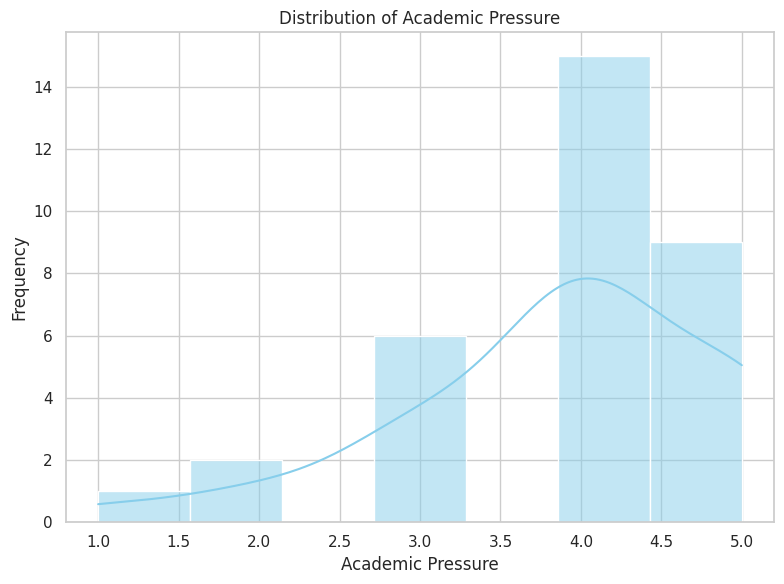

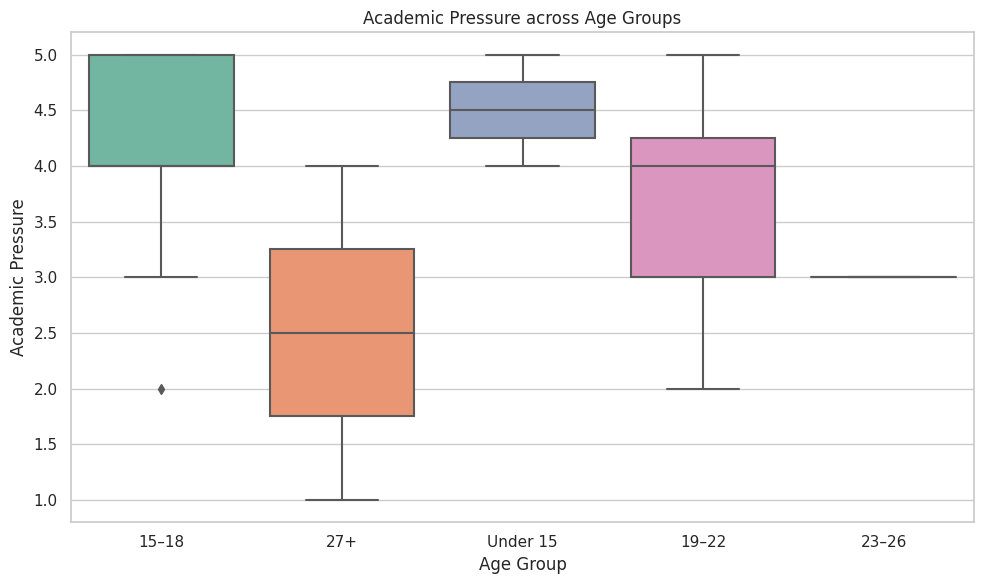

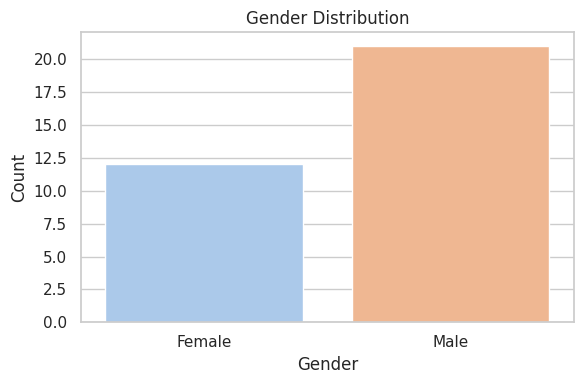

In [4]:
# Visualizations

# Let's create a few plots to better understand the data.

# Histogram of the academic pressure values
plt.figure(figsize=(8, 6))
sns.histplot(df[pressure_col], kde=True, color='skyblue')
plt.title('Distribution of Academic Pressure')
plt.xlabel('Academic Pressure')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Box plot of academic pressure by Age Group
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age Group', y=pressure_col, data=df, palette='Set2')
plt.title('Academic Pressure across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Academic Pressure')
plt.tight_layout()
plt.show()

# Count plot for Gender distribution (Note: original column name might have extra spaces)
gender_col = 'Gender'
if not any(gender_col in col for col in df.columns):
    # Attempt to find a column name that includes 'Gender'
    gender_col = [col for col in df.columns if 'Gender' in col][0]

plt.figure(figsize=(6, 4))
sns.countplot(x=gender_col, data=df, palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# If there are four or more numeric columns, display a correlation heatmap.
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap (Numeric Features)')
    plt.tight_layout()
    plt.show()

# Pair plot for numeric variables
if numeric_df.shape[1] >= 2:
    sns.pairplot(numeric_df, diag_kind='hist', corner=True, palette='muted')
    plt.suptitle('Pair Plot of Numeric Variables', y=1.02)
    plt.show()


Prediction R2 Score: -0.6426052631578947


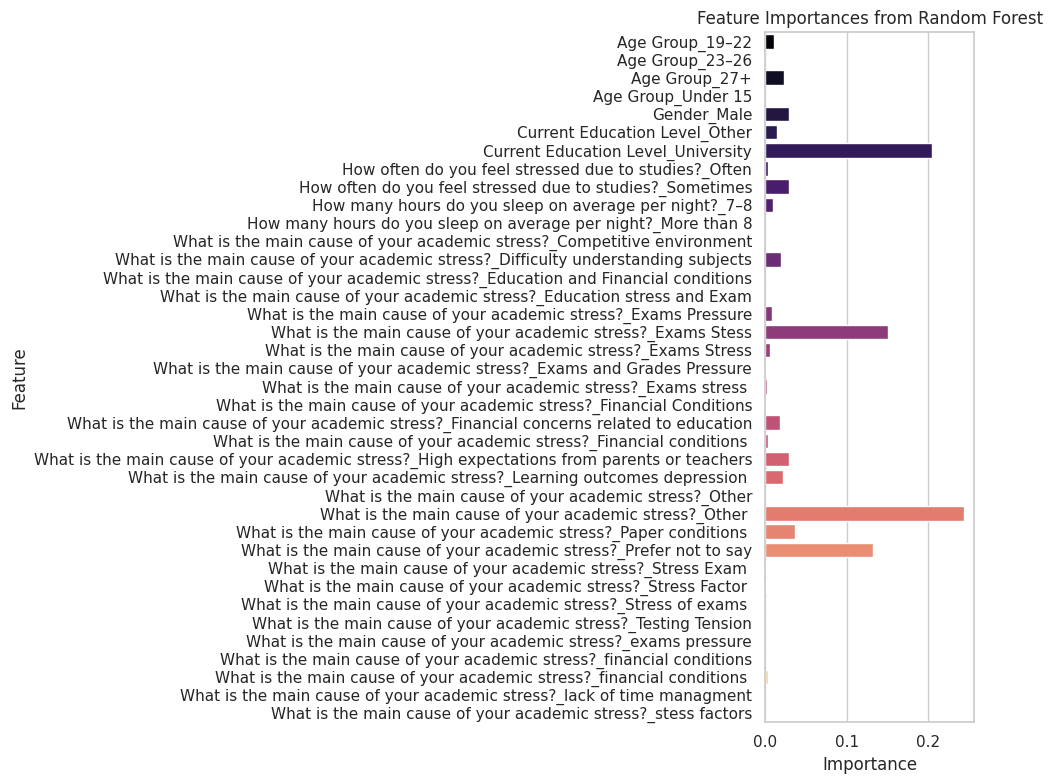

Predictive modeling complete.


In [5]:
# Predictive Modeling: Predicting Academic Pressure

# For the predictor, we will use a RandomForestRegressor to predict the numeric academic pressure

# First, make a copy of the dataframe and drop the Timestamp column as it is not predictive
df_model = df.copy()
if 'Timestamp' in df_model.columns:
    df_model = df_model.drop('Timestamp', axis=1)

# Ensure the target column name is updated to the trimmed name
pressure_col = pressure_col.strip()

# Again, drop any remaining rows missing the target variable (should be already handled)
df_model = df_model.dropna(subset=[pressure_col])

# Convert categorical variables to dummy variables
df_model = pd.get_dummies(df_model, drop_first=True)

# After converting to dummies, it is crucial to ensure there are no missing values in our feature set
df_model = df_model.dropna()

# Separate the dataset into features (X) and target (y)
X = df_model.drop(pressure_col, axis=1)
y = df_model[pressure_col]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the prediction accuracy using the R2 score
accuracy = r2_score(y_test, y_pred)
print('Prediction R2 Score:', accuracy)

# Display feature importances
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=features, palette='magma')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print('Predictive modeling complete.')

## Discussion and Future Work

The analysis steps above began with a curiosity about the drivers of academic pressure among students. The data was carefully cleaned and preprocessed, especially handling missing values and ensuring the date types were correctly inferred. Various visualizations provided insights into the distribution and relationships of the variables.

In the predictive modeling section, a RandomForestRegressor was used to predict academic pressure. Although the model produced an R2 score on the test set, there is clear room for improvement by:

- Conducting hyperparameter tuning or cross-validation
- Experimenting with imputation methodologies within a pipeline
- Exploring alternative models such as Gradient Boosting or XGBoost, some of which natively handle NaN values

Future analysis could also involve feature engineering based on the timestamp or textual analysis on stress causes. If you find this notebook useful, please upvote it.